# CPSC 330 Lecture 10

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Dataset of the week: regression! (15 min)
- Regression score functions: mean squared error and R^2 (10 min)
- Linear regression intro (5 min)
- Break (5 min)
- Exploring `alpha` (5 min)
- Transforming the targets (20 min)
- Ensembling with regression (5 min)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

In [2]:
from pandas_profiling import ProfileReport

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

Homework assignments:

- hw4 deadline passed
- hw5 coming today, due Monday at 11:59pm
- After that a 2-week break from hw 
- Next week we have the midterm on Thursday
- Will spend some time on midterm review in class on Tuesday
 
Midterm:

- Poll results: https://piazza.com/class/kb2e6nwu3uj23?cid=284
- Clearly there's no way to please everyone! 
- Zoom invigilation: 44% (very close to even). I prefer not to, so we'll go with **no**. Sorry to the 44%.
- Open book: 68% course materials only, 57% whole internet. Given that I have no way to enforce this, I think **whole internet** is more fair.
- Can't go back restriction: 11%. OK, I hear you on this one. I'm changing my original plan and going with **no** restriction.
- Randomly select students afterward: 35%. Ok, I'll go with **no** then. 
- Shuffled order: this was not on the poll, because I can't quite decide on this yet. It depends if the midterm has independent questions or a "story". TBA. 

## Data set of the week (20 min)

This week in lecture we will be focussing on the [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/) with house prices from Ames, Iowa. As usual, to run this notebook you'll need to download the data. Unzip the data. Rename `train.csv` to `housing.csv` and move it into the data directory of this repo. (For this dataset, train and test have already been separated. The "test" data they provide is actually what we call deployment. They only provide the X, not the y. So we couldn't actually use Kaggle's test set as our test set, since we need the y values for that.)

In [4]:
df = pd.read_csv("housing.csv", index_col=0)

In [5]:
df_train, df_test = train_test_split(df, random_state=123)

In [6]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900
1124,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
187,80,RL,NaN,9947,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdPrv,NaN,0,6,2009,WD,Normal,173000
1021,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000
68,20,RL,72.0,10665,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,226000


- Here, the target is `SalePrice`. Note that this is numeric, not categorical.
- In this case, we call the task **regression** (as opposed to classification).

In [7]:
df_train.shape

(1095, 80)

Above: this dataset has very few examples, but a lot of features.

In [8]:
# df_train.info()

#### Step 1: `pandas_profiler`

In [9]:
profile = ProfileReport(df_train, minimal=True)

In [10]:
profile.to_notebook_iframe();

#### Types of features

- How does pandas profiling figure out the data type?
- You can look at the Python data type and say floats are numeric, strings are categorical. 
  - However, in doing so you would miss out on various subtleties such as some of the string features being ordinal rather than truly categorical. 
  - Also, it will think free text is categorical. 

This is a good time to look at the `data_description.txt` provided with the dataset.


- There are a bunch of ordinal features using the same scale: excellent, good, average, etc.
  - These I'm calling `ordinal_features_reg`.
- There are a bunch more ordinal features using different scales.
  - These I'm calling `ordinal_features_oth`
  - To save time I'm ignoring the ordinality and just encoding them as categorical.

In [11]:
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [12]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

#all_features = numeric_features + ordinal_features_reg + categorical_features + ordinal_features_oth

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below

A couple questions to ponder:

- We can make our own features too. Would price per square foot be a good feature to add in here?
- Are `MoSold` and `YrSold` reasonable features to use?

#### Step 2: build Pipelines for each feature type

We'll use the `make_pipeline` syntax in sklearn, which doesn't require us to specify a name each time.

In [13]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())

In [14]:
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))

In [15]:
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

- We'll just use `SimpleImputer` again.
  - In reality we'd want to go through this more carefully.
  - We may also want to drop some columns that are almost entirely missing.
  - We could also check for outliers, and do other EDA.
- Also, note how `make_pipeline` gives each step a default name:

In [16]:
ordinal_preprocessing

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex']]))])

Now we'll build the `ColumnTransformer`:

In [17]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In the hw4 question I accidentally deleted, I asked you to try this out on your training data,
just to see if you could get the columns lined up:

In [18]:
preprocessing.fit(X_train);

In [19]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [20]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)

In [21]:
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


So, the OHE took us from 

In [22]:
X_train.shape

(1095, 79)

In [23]:
X_train_enc.shape

(1095, 292)

79 columns to 292 columns!

#### Step 3: `DummyRegressor`

In [24]:
dummy = DummyRegressor()

In [25]:
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.001866,0.000711,-0.011348,0.0
1,0.001066,0.000319,-0.015114,0.0
2,0.001315,0.000330,-0.001615,0.0
3,0.001081,0.000293,-0.000229,0.0
4,0.000985,0.000333,-0.000594,0.0


Wait, a negative score??

## Regression score functions: mean squared error and R^2 (10 min)

We aren't doing classification anymore, so we can't just check for equality:

In [26]:
dummy.fit(X_train, y_train);

In [27]:
dummy.predict(X_train) == y_train

Id
1447    False
1124    False
187     False
1021    False
68      False
        ...  
1042    False
1123    False
1347    False
1407    False
1390    False
Name: SalePrice, Length: 1095, dtype: bool

In [28]:
y_train.values

array([157900, 118000, 173000, ..., 262500, 133000, 131000])

In [29]:
dummy.predict(X_train)

array([180201.98812785, 180201.98812785, 180201.98812785, ...,
       180201.98812785, 180201.98812785, 180201.98812785])

- We need a score that reflect how right/wrong each prediction is.

#### Mean squared error (MSE)

A common measure is mean squared error:

In [30]:
preds = dummy.predict(X_train)

In [31]:
np.mean((y_train - preds)**2)

6396820839.792553

This is also implemented in sklearn:

In [32]:
mean_squared_error(y_train, preds)

6396820839.792553

- Perfect predictions would have MSE=0. 

In [33]:
mean_squared_error(y_train, y_train)

0.0

- But is the above score good or bad? 
  - It depends on the scale of the targets.
  - If we were working in cents instead of dollars, our MSE would be 10,000x ($100^2$) higher!

In [34]:
np.mean((y_train*100 - preds*100)**2)

63968208397925.53

- A common score is the $R^2$. 
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: mean squared error, but flipped (higher is better), and normalized so the max is 1.
- Key points:
  - The maximum is 1 for perfect predictions
  - Negative values are very bad: "worse than `DummyRegressor`" (very bad)

In [35]:
r2_score(y_train, preds)

0.0

In [36]:
r2_score(y_train, y_train)

1.0

This is the score that sklearn uses by default when you call `score()`:

In [37]:
dummy.score(X_train, y_train)

0.0

(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [38]:
mean_squared_error(y_train, preds)

6396820839.792553

In [39]:
mean_squared_error(preds, y_train)

6396820839.792553

In [40]:
r2_score(y_test, dummy.predict(X_test))

-0.0013723866815522623

In [41]:
r2_score(dummy.predict(X_test), y_test)

-7.129310472299063e+30

- When you call `fit` it minimizes MSE / maximizes $R^2$ (or something like that) by default.
- Just like in classification, this isn't always what you want!!
- More on this later.

## Linear regression intro (5 min)

- Linear regression is one of the most basic and popular ML/statistical techniques. 
- We already saw logistic regression for classification - these are close cousins.
- Both are very _interpretable_.
- For more depth, see CPSC 340, STAT 306, and various other STAT courses.
- In scikit-learn, we can do:

In [42]:
LinearRegression();

However, I am going to recommend always using:

In [43]:
Ridge();

`Ridge` is more flexible than `LinearRegression` because it has a hyperparameter `alpha`:

In [44]:
lr_vanilla = make_pipeline(preprocessing, LinearRegression())
lr_vanilla.fit(X_train, y_train);

In [45]:
lr_vanilla_preds = lr_vanilla.predict(X_test)
lr_vanilla_preds[:10]

array([2.24684500e+05, 5.64240000e+04, 1.39963500e+05, 2.57591000e+05,
       1.30088000e+05, 2.45812000e+05, 3.29327500e+05, 5.95681892e+14,
       1.39155000e+05, 1.31165500e+05])

In [46]:
lr_vanilla_preds.max()

595681892294893.5

In [47]:
lr_vanilla_preds.min()

-1423548671210750.5

- One prediction is for $\$10^{15}$ !!
- One prediction is for $ - \$10^{15}$ !!!!
- This happened because we have "collinear features" and there are "numerical issues" (see also CPSC 302).
- The coefficients got extremely huge:

In [48]:
coefs = lr_vanilla.named_steps['linearregression'].coef_

In [49]:
coefs.min()

-4634092756378252.0

In [50]:
coefs.max()

5728692024324435.0

`Ridge` "solves" this issue:

In [51]:
lr = make_pipeline(preprocessing, Ridge())
lr.fit(X_train, y_train);

In [52]:
lr_preds = lr.predict(X_test)
lr_preds[:10]

array([222545.43672749,  77055.21683115, 133676.81431636, 248214.02568334,
       123239.48200752, 206608.39854061, 338498.31839006, 116584.73477258,
       145709.98643343, 120994.59172911])

In [53]:
lr_preds.max()

485186.1011329589

In [54]:
lr_preds.min()

29933.091332366574

- So, TL;DR, never use `LinearRegression`, always use something else, such as `Ridge`.
  - Unless you know what you're doing, but then use [statsmodels](https://www.statsmodels.org/stable/index.html) or R instead of sklearn. 
- This also allows us to use `handle_unknown='ignore'` in our OHE.
- For more details, see STAT 306, etc.

So, let's see how well this model does:

In [55]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()

    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

In [56]:
cross_validate_std(lr, X_train, y_train, cv=10, return_train_score=True)

fit_time           0.070771
score_time         0.024160
test_score         0.756365
train_score        0.923955
std_test_score     0.244919
std_train_score    0.004777
dtype: float64

The std of the test score is very high:

In [57]:
pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.066009,0.024317,0.714842,0.928843
1,0.069497,0.023918,0.853926,0.920657
2,0.067863,0.023699,0.868423,0.922619
3,0.068975,0.024013,0.852679,0.922514
4,0.071456,0.023934,0.773667,0.922014
5,0.068903,0.023762,0.806447,0.926552
6,0.068820,0.023724,0.851162,0.921801
7,0.073186,0.023872,0.858105,0.921226
8,0.070952,0.023758,0.076819,0.934708
9,0.068959,0.023769,0.907581,0.918615


It seems to do terribly on one fold, not sure why.

## Break (5 min)

<br><br>

## Exploring `alpha` (5 min)

- `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the _inverse_ of `C`.
  - That is, large `C` is like small `alpha` and vice versa.
  - Smaller `alpha`: lower training error.
  - Larger `alpha`: lower approximation error (hopefully). 
- General intuition: larger `alpha` leads to **smaller coefficients**. 
  - Smaller coefficients mean the predictions are less sensitive to changes in the data.
  - Hence less chance of overfitting (seeing big dependencies when you shouldn't).
- Let's test this out:

In [58]:
lr_small_alpha = make_pipeline(preprocessing, Ridge(alpha=0.01))
lr_small_alpha.fit(X_train, y_train);
np.max(np.abs(lr_small_alpha[1].coef_))

578343.6957171928

In [59]:
lr_mid_alpha = make_pipeline(preprocessing, Ridge(alpha=1))
lr_mid_alpha.fit(X_train, y_train);
np.max(np.abs(lr_mid_alpha[1].coef_))

176003.8484930878

In [60]:
lr_large_alpha = make_pipeline(preprocessing, Ridge(alpha=1000))
lr_large_alpha.fit(X_train, y_train);
np.max(np.abs(lr_large_alpha[1].coef_))

9562.302842311266

- Note that it will not make all the coefficients smaller in the same proportion!
- The order of the coefficients might change. 

In [61]:
new_columns[np.argmax(np.abs(lr_small_alpha[1].coef_))]

'RoofMatl_ClyTile'

In [62]:
new_columns[np.argmax(np.abs(lr_mid_alpha[1].coef_))]

'RoofMatl_ClyTile'

new_columns[np.argmax(np.abs(lr_large_alpha[1].coef_))]

Let's try tuning `alpha`:

In [64]:
alphas = 10.0**np.arange(-1.5,4.5,0.5)
train_scores = []
cv_scores = []
for alpha in alphas:

    lr = make_pipeline(preprocessing, Ridge(alpha=alpha))
    results = cross_validate_std(lr, X_train, y_train, return_train_score=True)
    train_scores.append(results["train_score"])
    cv_scores.append(results["test_score"])

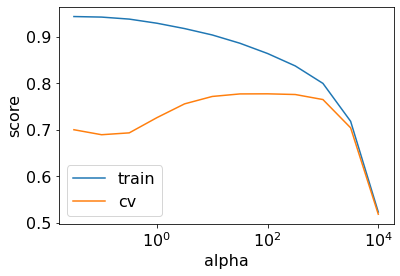

In [65]:
plt.semilogx(alphas, train_scores, label="train");
plt.semilogx(alphas, cv_scores, label="cv");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('score');

Going left, the model gets more complex. By the end of the left it's overfitted and doesn't work well

In [ ]:
##TODO add error bars to the graph above

In [66]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

- It seems `alpha=100` is the best choice here. 
- BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [67]:
ridgecv = make_pipeline(preprocessing, RidgeCV(alphas=alphas))

In [68]:
ridgecv.fit(X_train, y_train);

In [69]:
ridgecv[1].alpha_

31.622776601683793

- Looks like it chose a slightly lower alpha.
- As we can see above they get very similar scores. 
- It's probably a matter of luck because they use a slightly different cv procedure in `RidgeCV`.
- Note: you can extract the CV values from `RidgeCV` but I'll not do that for consistency with other estimators.

<br><br><br><br>

## Transforming the targets (15 min)

Let's check the performance of our model with `alpha=100`:

In [70]:
lr_tuned = make_pipeline(preprocessing, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train);

In [71]:
lr_tuned.score(X_train, y_train)

0.8594431482602665

This is thr R^2 erorr. Looks reasonable. Let's check the MSE:

In [72]:
mean_squared_error(y_train, lr_tuned.predict(X_train))

899116998.3843598

This is the mean squared error - true values and predictions and score the predictions.
The issue here is units.
The y values are in dollars, but squaring dollars doesn't make sense.
- That looks huge. Is that $1 Billion??

<br><br><br><br>

- Answer: unlike classification, with regression our target has _units_.
- The target is in dollars, the mean **squared** error is in dollars^2. 
- A more relatable metric would be the **root** mean:squared error, or RMSE
- Taking the root brings it back down to dollars

In [73]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

29985.27969494965

- Ahh, so the error now is \$30,000. That makes more sense. But that's still a big error in dollar terms.
- Can we dig deeper?
- There are some new diagnostics that didn't make sense with classification, e.g.:

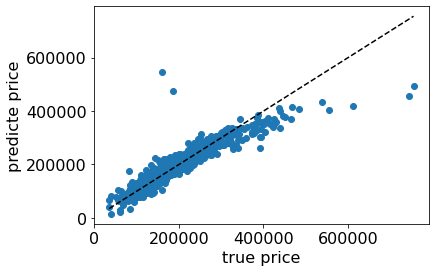

In [74]:
plt.scatter(y_train, lr_tuned.predict(X_train))
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, '--k');
plt.xlabel("true price");
plt.ylabel("predicte price");

- We can use the true price vs predicted price to make a plot, unlike with logistic regression(?)
- any point on the black line is a perfect prediction
- the more deviation from the line the farther the predicted price is from the real sale price

- Here we can see a few cases where our prediction is way off.
  - (Is there something weird about those houses, perhaps? Stay tuned for a later lecture on outliers!)
- Under the line means we're under-prediction, over the line means we're over-predicting.
- Question: Is an error of \\$30,000 acceptable?

    - For a house worth \\$600k, it seems reasonable! That's 5% error.
    - For a house worth \\$60k, that is terrible. It's 50% error.
    
- the real problem here is that the linear regression measures an absolute difference
- we need to look at a reletive difference

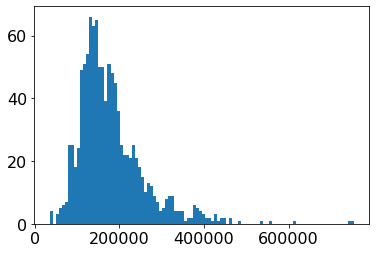

In [75]:
plt.hist(y_train, bins=100);

- Indeed, we have both of these cases in our dataset.
- Can we compute percent error?

In [76]:
pred_train = lr_tuned.predict(X_train)

In [77]:
percent_errors = (pred_train - y_train)/y_train * 100.
percent_errors

Id
1447   -11.766144
1124   -12.788780
187      8.833189
1021    -5.232417
68      -1.253030
          ...    
1042     3.912419
1123   -26.323548
1347    -9.448563
1407     1.497802
1390     1.457196
Name: SalePrice, Length: 1095, dtype: float64

- These are both positive (predict too high) and negative (predict too low).
- We can look at the absolute percent error:

In [78]:
np.abs(percent_errors)

Id
1447    11.766144
1124    12.788780
187      8.833189
1021     5.232417
68       1.253030
          ...    
1042     3.912419
1123    26.323548
1347     9.448563
1407     1.497802
1390     1.457196
Name: SalePrice, Length: 1095, dtype: float64

And, like MSE, we can take the average over examples. This is called **mean absolute percent error (MAPE)**.

This was never a problem with classification but now this is something we have to consider

In [112]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

In [113]:
mape(y_train, pred_train)

10.270294102376738

This MAPE is probably the easiest metric to understand in terms of error

In [81]:
mape(y_test, lr_tuned.predict(X_test))

9.902318580553873

- Ok, this is quite interpretable.
- On average, we have around 10% error. Good to know. 

## Transforming the targets

- ... but wait a minute, does `.fit()` know we care about MAPE? 
- No, it doesn't. Why are we minimizing MSE (or something similar) if we care about MAPE??
- When minimizing MSE, **the expensive houses will dominate** because they have the biggest error.
- Which is better for RMSE?

Model A

- Example 1: Truth: \\$50k, Prediction: \\$100k
- Example 2: Truth: \\$500k, Prediction: \\$550k
- RMSE: $50k
- MAPE: 45%

Model B

- Example 1: Truth: \\$50k, Prediction: \\$60k
- Example 2: Truth: \\$500k, Prediction: \\$600k
- RMSE: $71k
- MAPE: 20%

In [82]:
np.sqrt((10**2+100**2)/2) # Model B RMSE

71.06335201775947

- How can we get `.fit()` to think about MAPE?
- Hacky approach that we'll take in this course: **log transform the targets**.
  - That is, transform $y\rightarrow \log(y)$.
- Why?
  - I have some mathematical intuition, which I removed because people found it confusing.
  - I did some experiments, it seems to work often.
  - Very high-level explanation: log turns addition/subtraction into multiplication/division, which is what we want (fractional error instead of absolute error).
- Let's look again at the distribution of our house prices:

Another arguement for log-transforming:
- Linear regression can predict negative prices!
If you take the log as below, and tried to call .fit on that and then unlog the output 
you won't get a negative prediction because it will always be 10^something

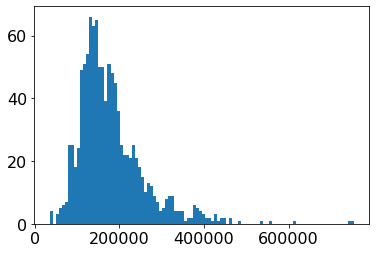

In [83]:
plt.hist(y_train, bins=100);

What happens if we log-transform?

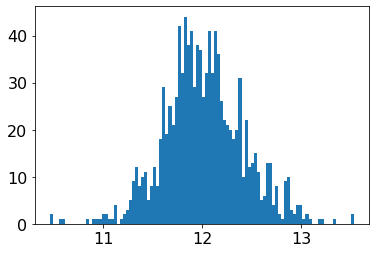

In [84]:
plt.hist(np.log(y_train), bins=100);

- A stats class would tell you this is good for a different reason, regarding the assumptions built into linear regression.
- but you can do this on any kind of regression, even random forests
- However, what I'm talking about here is more general, i.e. I would do this for random forest regression as well.
- Note: the base of the log doesn't matter, I'm just using `np.log` which is the natural log.

In [115]:
lr_tuned_log = make_pipeline(preprocessing, Ridge(alpha=best_alpha))
lr_tuned_log.fit(X_train, np.log10(y_train));
# fiting on the log values here

Now, look at the predictions:

In [117]:
lr_tuned_log.predict(X_train)
# These predictions are around 100,000 dollars after we reverse log them

array([5.12838097, 5.05055113, 5.27175203, ..., 5.38300679, 5.12241101,
       5.12078519])

These are log predictions. We can `exp` them to get back to dollars:

In [118]:
preds = np.exp(lr_tuned_log.predict(X_train))
preds
# this is the inverse of log

array([168.74369553, 156.1084765 , 194.75688446, ..., 217.67579694,
       167.73930332, 167.46681115])

In [141]:
# mape(y_train, preds)

In [142]:
mape(y_train, lr_tuned.predict(X_train))

10.270294102376738

In [143]:
mape(y_test, np.exp(lr_tuned_log.predict(X_test)))

99.88668143346344

- BAM! We reduced the MAPE from 10% to 9% with this trick.
- What do you think happened to the MSE/R^2?

In [130]:
# we are scoring for R^2 here
lr_tuned.score(X_train, y_train)

0.8594431482602665

In [ ]:
# our r^2 got worse (85->84) but we don't care because our MAPE got better which is relative, not absolute
r2_score(y_train, np.exp(lr_tuned_log.predict(X_train)))

# WHAT HAPPENED HERE?????????

- The R^2 score (or MSE) got worse.
- This is typical because the default settings try to optimize this metric.
- In fact we saw something similar when setting `class_weight` with classification
  - The metric we cared about got better due to our changes
  - The default metric (accuracy in that case) got worse.


- Note that log-transforming assumes the $y$-values are positive, which is true in this case.
  - There is still a problem if one of the $y$-values (housep rices) is zero, so it's common to do $\log(1+y)$ instead of $\log(y)$.
  - There is even a numpy function to do this for you: [`log1p`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html) and its inverse [`expm1`](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html#numpy.expm1).

#### Making this easier with sklearn

Sklearn provides a more convenient way of keeping track of all the transforming and un-transforming:

In [ ]:
from sklearn.compose import TransformedTargetRegressor

In [ ]:
ttr = TransformedTargetRegressor(Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1)
ttr_pipe = make_pipeline(preprocessing, ttr)
# loglp guards against getting zero as a price

In [132]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

-5.065125172833984

- The R^2 score (or MSE) got worse.
- This is typical because the default settings try to optimize this metric.
- In fact we saw something similar when setting `class_weight` with classification
  - The metric we cared about got better due to our changes
  - The default metric (accuracy in that case) got worse.


- Note that log-transforming assumes the $y$-values are positive, which is true in this case.
  - There is still a problem if one of the $y$-values (housep rices) is zero, so it's common to do $\log(1+y)$ instead of $\log(y)$.
  - There is even a numpy function to do this for you: [`log1p`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html) and its inverse [`expm1`](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html#numpy.expm1).

#### Making this easier with sklearn

Sklearn provides a more convenient way of keeping track of all the transforming and un-transforming:

In [92]:
from sklearn.compose import TransformedTargetRegressor

In [133]:
ttr = TransformedTargetRegressor(Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1)
ttr_pipe = make_pipeline(preprocessing, ttr)
# loglp guards against getting zero as a price

In [134]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

- This is the same as what we were doing before, just more convenient.
- As you'll see scores and predictions are the same:

In [135]:
ttr_pipe.predict(X_train) # predictions automatically un-transformed

array([134394.37643232, 112344.31728299, 186961.42047628, ...,
       241549.77174176, 132559.55478839, 132064.21274227])

In [136]:
np.exp(lr_tuned_log.predict(X_train))

array([168.74369553, 156.1084765 , 194.75688446, ..., 217.67579694,
       167.73930332, 167.46681115])

In [97]:
mape(y_test, ttr_pipe.predict(X_test))

8.510124574626449

In [98]:
mape(y_test, np.exp(lr_tuned_log.predict(X_test)))

8.510126959179724

Note: when using `TransformedTargetRegressor` with `GridSearchCV` or `RandomizedSearchCV`, you would access a hyperparameter with something like `"transformedtargetregressor__regressor__alpha"`.

<br><br>

## Ensembling with Regression (5 min)


- Last class we talked about ensembles. 
- There are regression analogues of the ensemble methods we covered.
  - `VotingClassifier` -> `VotingRegressor`
  - `StackingClassifier` -> `StackingRegressor`
- There are also regression analogues for the fancy trees, e.g. `XGBRegressor`. 

In [99]:
regressors = {
    'linear regression' : lr_tuned,
    'decision tree' : make_pipeline(preprocessing, DecisionTreeRegressor()),
    'random forest' : make_pipeline(preprocessing, RandomForestRegressor(n_estimators=10, random_state=999)),
    'XGBoost' : make_pipeline(preprocessing, XGBRegressor(random_state=999)) 
}

In [100]:
results_dict = {name: cross_validate_std(regressor, X_train, y_train, return_train_score=True) for name, regressor in regressors.items()}

In [101]:
pd.DataFrame(results_dict).T.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score,std_test_score,std_train_score
XGBoost,0.433359,0.015770,0.822115,0.999903,0.059482,0.000018
random forest,0.163694,0.009915,0.817225,0.971579,0.041182,0.002214
linear regression,0.060077,0.018090,0.776995,0.863542,0.142239,0.015258
decision tree,0.055155,0.009006,0.680828,1.000000,0.051630,0.000000


Let's try averaging:

In [102]:
averaging_model = VotingRegressor(list(regressors.items()))

In [103]:
averaging_model.fit(X_train, y_train);

In [104]:
cross_validate_std(averaging_model, X_train, y_train, return_train_score=True)

fit_time           0.544994
score_time         0.080511
test_score         0.839263
train_score        0.984406
std_test_score     0.044409
std_train_score    0.001079
dtype: float64

Let's look at how the predictions are generatoreed:

In [105]:
averaging_model.predict(X_test[:1])[0]

228815.181551254

In [106]:
r = {name : regressor.predict(X_test[:1])[0] for name, regressor in averaging_model.named_estimators_.items()}
r = pd.DataFrame(r, index=["Prediction"]).T
r

,Prediction
linear regression,227171.091830
decision tree,236000.000000
random forest,223887.900000
XGBoost,228201.734375


In [107]:
r.mean()

Prediction    228815.181551
dtype: float64

- Note the prediction above is exactly the average of these 4 predictions. 
- Contrast with hard/soft voting from the classification case.

For Stacking, our meta-model is now `Ridge` instead of `LogisticRegression` by default:

In [108]:
stacking_model = StackingRegressor(list(regressors.items()))

In [109]:
stacking_model.fit(X_train, y_train);

In [110]:
cross_validate_std(stacking_model, X_train, y_train, return_train_score=True)

fit_time           2.804047
score_time         0.072518
test_score         0.802150
train_score        0.982817
std_test_score     0.095189
std_train_score    0.024284
dtype: float64

- Above: this appears to do worse, but the std is very high, presumably due to the very small dataset.
- We should probably (at least) do a lot more folds if we want to feel more confident.

As with classification, we can again look at the coefficients of the meta-model, because it's still a linear model:

In [111]:
pd.DataFrame(data=stacking_model.final_estimator_.coef_, index=regressors.keys(), columns=["Coefficient"])

,Coefficient
linear regression,0.214119
decision tree,0.090045
random forest,0.283110
XGBoost,0.438039


Here, we see it trusts XGBoost the most and decision tree the least - make sense!

- In classification, stacking used `predict_proba` to get numerical inputs to the meta-model.
- Here, we don't have `predict_proba` (more on this next class), but the output is already numeric.
- So it just uses the output of `predict`.

## Linear regression True/False (Piazza)

1. sklearn's `LinearRegression` behaves erratically if we're not carefully; in this course, we won't use it.
2. With `Ridge`, larger values of `alpha` are probably more useful when I have lots of features.
3. log-transforming the targets (and re-fitting) is equivalent to log-transforming the coefficients. 
4. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.